# Osztályozás PyTorch segítségével - XOR probléma
Itt az idő, hogy PyTorch segítségével készítsünk egy osztályozót! Először a hírhedt XOR problémát oldjuk meg, majd mesterségesen előállított adatokon osztályozunk, végül pedig az Iris adathalmazon.

Először importáljuk be a PyTorch könyvtárat:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

Készítsük el a hálónkat! A neurális hálónk, amit a XOR problémára készítünk el, csupán két réteget fog tartalmazni: amint látni fogjuk, ez valóban elegendő a probléma megoldására. Köztudott, hogy egy perceptron önmagában nem elegendő a probléma megoldására.

Alapvetően egyszerű lineáris osztályozókat fogunk használni. A bemenet tetszőleges dimenziójú lehet (nyilván 2-dimenzióban a legkézzelfoghatóbb a probléma). Ezt a bemenetet elegendő két perceptronnal kétfelé bontani, majd végül összefogni a külső rétegben.

A Pytorch egy jellegzetessége, hogy objektumorientált, minden hálózat az __nn.Module__ osztályból származik. A következő függvények kellenek minimálisan:
- A konstruktorban (__init__) definiáljuk a rétegeket, azok működését, dimenzionalitását
- A __forward__ függvénnyel határozzuk meg az egyes rétegek közötti kapcsolatokat. Az egyes rétegek között egy aktivációs függvénnyel építhető fel a kapcsolat (ezt hasnzáljuk fel a parciális derivált számításához). A forward függvény minden bemenet esetén végrehajtódik (ez a függvény argumentuma(i)). Mivel a PyTorch alapvetően egy autograd rendszer, amely egy számítási gráfban számít parciális derviáltakat, így egészen egzotikus kapcsolatok is létrehozhatóak. Jelen pillanatban azonban a feedforward hálózatokra összpontosítunk.

Ezek alapján a XOR megoldó hálózat:

In [2]:
class XORSolver(nn.Module):
    def __init__(self, input_dim=2, output_dim=1):
        super(XORSolver, self).__init__()
        self.linear = nn.Linear(input_dim,2)
        self.linear2 = nn.Linear(2, output_dim)
        
    def forward(self, x):
        x = self.linear(x)
        x = F.sigmoid(x)
        x = self.linear2(x)
        return F.sigmoid(x)

A hálózat példányosítása:

In [3]:
net = XORSolver()

A hálózat példányosítását követően a súlyokat valamilyen (közel 0) értékre kell inicializálni. A PyTorchban több beépített módszer áll rendelkezésre, de most saját megoldást mutatunk be. Ezt megtehetjük az alábbi módon:

In [4]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # initialize the weight tensor, here we use a normal distribution
            m.weight.data.normal_(0, 1)
weights_init(net)

Készítsük el az adathalmazunkat:

In [5]:
# Data
import numpy as np
X = np.array([
    [-3.0, 3.0],
    [-2.4, 1.5],
    [-2.12, -1.85],
    [-0.7, -0.5],
    [0.27, 0.45],
    [1.97, -2.45],
    [1.27, -1.45],
    [2.27, 3.45],
])

y = np.array([
    1,
    1,
    0,
    0,
    0,
    1,
    1,
    0
])

Látható miképp különül el a két osztály:

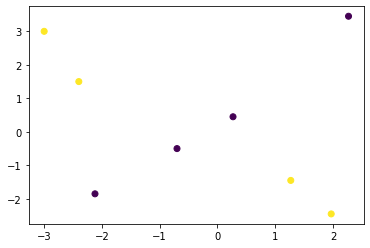

In [6]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:, 1], c=y)

Definiáljunk néhány hiperparamétert:
- 2000 epizódig futtatjuk a tanítást
- Mivel egyszerre egy adat kerül a hálóba a tanítás során, így az egyes epizódok a bemeneti adat sorainak felel meg.
- A hibafüggvény legyen MSE
- Az optimalizáló függvény Adam
- Követjük bizonyos időközönként a hibafüggvényt (a plt_iter jelzi)

In [7]:
# Hyperparameters
epochs = 2000
steps = X.shape[0]
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.03)
all_losses = []
current_loss = 0
plt_iter = 10

A numpy tömböket át kell alakítani a PyTorch-ban használt adattípusokra:

In [8]:
X_ = torch.from_numpy(X).type(torch.FloatTensor)
y_ = torch.from_numpy(y).type(torch.FloatTensor)

A bemeneti adatok segítségével vizualizálható a hálózat rétegei:

C:\Anaconda3\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


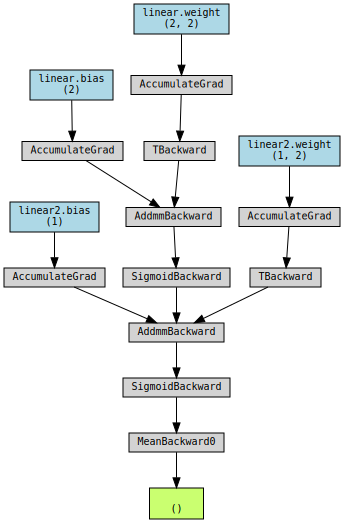

In [9]:
from torchviz import make_dot
make_dot(net(X_).mean(), params=dict(net.named_parameters()))

Látható, hogy minden egyes csomópont rendelkezik egy gradienseket akkumuláló csomóponttal, amely tulajdonképp egy belépési pontját jelenti a rétegnek (itt hozzáférhetőek az egyes paraméterek). Mivel réteg paraméterekről van szó, így a dimenzionalitás a neuronszámnak megfelelően fog változni.

Kezdjük el a tanítást. Ha biztosak akarunk lenni abban, hogy mindig új hálón tanulunk, a következőt kell tenni:
- A hálót példányosítsuk újra
- Inicializáljuk a háló súlyait
- Példányosítsunk egy optimalizálót
- Súlyok definiálása

Bizonyos időközönként írjuk ki a hiba alakulását. Ha minden jól megy, akkor azt tapasztaljuk, hogy csökken a hiba:

C:\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


499 completed, Loss 0.0004971593734808266
999 completed, Loss 5.2533338021021336e-05
1499 completed, Loss 6.8345411818881985e-06
1999 completed, Loss 9.183871156892565e-07


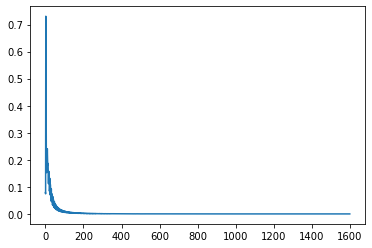

In [10]:
net = XORSolver()
weights_init(net)
optimizer = torch.optim.Adam(net.parameters(), lr = 0.03)
all_losses = []
for epoch in range(epochs):
    for i in range(steps):
        x_var = Variable(X_[i], requires_grad=False)
        y_var = Variable(y_[i], requires_grad=False)
        
        optimizer.zero_grad()
        yhat = net(x_var)
        loss = loss_func.forward(yhat, y_var)    
        loss.backward()
        optimizer.step()
        
        current_loss += loss
        if epoch %  plt_iter == 0:
            all_losses.append(loss)
    if (epoch+1) % 500 == 0:
        print(f"{epoch} completed, Loss {loss}")
plt.plot(all_losses)

Tekintsük meg az egyes rétegek paramétereit. Estünkben a külső réteg paraméterei (várhatóan) egy $\theta$ súlyozásnak és egy hozzátartozó eltolásnak:

In [11]:
print(f"Parameters: \n {net.linear2.weight} \n {net.linear2.bias}")

Parameters: 
 Parameter containing:
tensor([[14.1783, 14.1913]], requires_grad=True) 
 Parameter containing:
tensor([-6.9980], requires_grad=True)


Várható, hogy a bemeneti rétegen a paraméterezés dimenzionalitása más lesz. Ebben az esetben $\theta$ egy $2\times 2$ mátrix lesz, a $b$ eltolás pedig egy kétdimenziós vektor:

In [12]:
print(f"Parameters: \n {net.linear.weight} \n {net.linear.bias}")

Parameters: 
 Parameter containing:
tensor([[-3.5281,  2.8503],
        [ 4.8748, -4.2582]], requires_grad=True) 
 Parameter containing:
tensor([-7.5262, -5.8672], requires_grad=True)


A betanított hálózat esetében látványos a döntési tartomány vizualizációja. Jól látható, hogy melyik ponton különül el az osztályozás a kontúrdiagrammon. A döntési tartomány vizualizációja a következő módon történik: létrehozunk egy mezőt, amin szeretnénk ezt a tartományt megjeleníteni, majd a mező elemeit adjuk bemenetként meg a neurális hálónak.

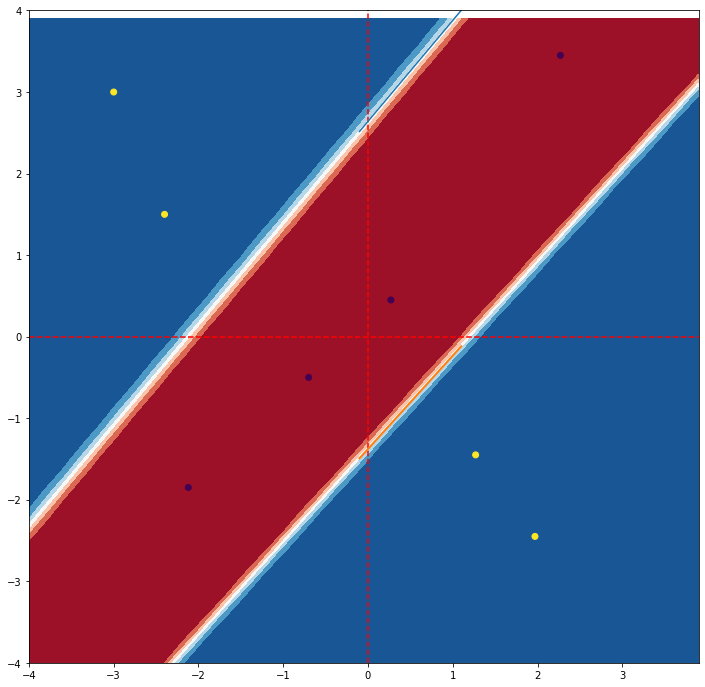

In [13]:
plt.figure(figsize=(12,12))
lt = np.linspace(-3, 3, 100)
plt.ylim((-4, 4))
# Plot contour
x1grid = np.arange(-4, 4, 0.1)
x2grid = np.arange(-4, 4, 0.1)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
#
yhat = net(torch.from_numpy(grid).type(torch.FloatTensor)).detach().numpy()
#
zz = yhat.reshape(xx.shape)
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# Show everything
plt.axvline(x=0, color='r', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
plt.scatter(X[:,0], X[:,1], c=y)



model_params = list(net.parameters())

model_weights = model_params[0].data.numpy()
model_bias = model_params[1].data.numpy()


x_1 = np.arange(-0.1, 1.1, 0.1)
y_1 = ((x_1 * model_weights[0,0]) + model_bias[0]) / (-model_weights[0,1])
plt.plot(x_1, y_1)

x_2 = np.arange(-0.1, 1.1, 0.1)
y_2 = ((x_2 * model_weights[1,0]) + model_bias[1]) / (-model_weights[1,1])
plt.plot(x_2, y_2, linewidth=2)

plt.show()